# Build Model and Generate Predictions

### Load Necessary Packages

In [17]:
import os
import time
import random

import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
import re
import gc

### Create function for checking memory usage of dataframes

In [2]:
def check_memory_usage(data):
    """ Takes DataFrame as input and returns memory usage statistics. 
    """
    print(data.info(memory_usage=True))    

###  Create custom evaluation metric, Root Mean Log Squared Error (RMSLE)

In [3]:
def RMSLE(actuals, predictions):
    """ Takes true values and predictions. Returns their Root Mean Squared Logarithmic Error.
    """
    result = 0.0
    actuals = np.asarray(actuals) * 1.0
    predictions = np.asarray(predictions)
    if(len(actuals) == len(predictions)):
        result = np.sqrt(sum(((np.log(predictions + 1.0) - np.log(actuals + 1.0)) ** 2) / len(actuals)))
        return result
    else: 
        return "Error!"

### Set seed for reproducibility purposes

In [4]:
random.seed(0)

### Load the data

In [5]:
def load_data(): 
    """ Loads and returns train and test data. 
    """
    # Set work directory
    os.chdir('C:/Users/kpajm/tfdeeplearning/ceptes_data/') 
    
    # Load data efficiently by setting numpy data types for variables
    train_types = {
         'Date': np.uint8, 'Product': np.uint16, 'Demand': np.uint8
         }  
         
    test_types = {
        'Date': np.uint8, 'Product': np.uint16
         }  
    
    train = pd.read_csv("data.csv", sep = ",", usecols = train_types.keys(), dtype = train_types) 
    test = pd.read_csv("data_test.csv", sep = ",", usecols = test_types.keys(), dtype = test_types) 

    return train, test   

In [6]:
print("1. Loading data...")
train, test = load_data() 
print("Complete!")
print('')
check_memory_usage(train)

1. Loading data...
Complete!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
Date       10000 non-null uint8
Product    10000 non-null uint16
Demand     10000 non-null uint8
dtypes: uint16(1), uint8(2)
memory usage: 39.1 KB
None


### Prepare data for model fitting

In [7]:
def prepare_data(train, test, cv_index):
    """ Divide train data into training data for model and a hold-out validation set
        based on Week value (can take 1, 2, 3, 4 as values). 
        
        Splits outcome variable from data for model.
        
        Converts and returns dataframes as numpy matrices.
    """
    # Reset data indices
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)       
      
    # Get CV indices from train (Date == cv_index)
    cv_indices = train[train['Date'] == cv_index].index
    train_indices = train[train['Date'] != cv_index].index
    
    # Data for model building
    column_names = list(train.drop(['Demand'], axis = 1).columns)
    y_train = train.loc[train_indices, 'Demand'].values
    X_train = train.loc[train_indices, :].drop(['Demand'], axis = 1).values
    y_validation = train.loc[cv_indices, 'Demand'].values
    X_validation = train.loc[cv_indices, :].drop(['Demand'], axis = 1).values
    
    # Return data
    return y_train, X_train, y_validation, X_validation, column_names

In [8]:
print("2. Preparing data for model building...")
cv_index = 2
y_train, X_train, y_validation, X_validation, column_names = prepare_data(train, test, cv_index)

# Remove original train data sets from memory
# del train
# gc.collect()

print("Complete!")

2. Preparing data for model building...
Complete!


### Define XGBOOST model and parameters

In [10]:
print("3. Create model and define parameters...")
xgb_params = {
             'objective': 'reg:linear'
             , 'n_estimators': 100 
             , 'learning_rate': 0.25 
             , 'max_depth': 12 
             , 'seed': 0
             }
model_xgb = xgb.XGBRegressor()                
model_xgb.set_params(**xgb_params)   

3. Create model and define parameters...


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.25, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

### Create function to plot XGBOOST learning curves during fitting process

In [11]:
def plot_learning_curves(model_xgb):
    """ Takes XGBOOST model fit on data. 
        Plots train and validation RMSE for each iteration of model.
    """
    # Retrieve model performance metrics
    results = model_xgb.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # Plot RMSE
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE Performance')
    plt.show()

### Create function to display XGBOOST feature importance scores

In [28]:
def feature_importance_scores(model_xgb, column_names, cv_index, cv_score): 
    """ Takes fit XGBOOST model, column names, validation set index, and validation RMSLE score as inputs. 
        Plot and saves XGBOOST feature importance scores.
    """
    # Create dataframe of feature importance scores
    fscore = model_xgb.get_booster().get_fscore()
    
    print(fscore)
    feature_importances = []
    for ft, score in fscore.items(): 
        ft = column_names[int(re.sub("[^0-9]","", ft))]
        feature_importances.append({'Feature': ft, 'Importance': score})
    feature_importances = pd.DataFrame(feature_importances)
    feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False).reset_index(drop=True)
    feature_importances['Importance'] = feature_importances['Importance'] / feature_importances['Importance'].sum()
    
    feature_names = feature_importances['Feature']
    importances = feature_importances['Importance']
    y_pos = np.asarray(range(len(feature_names), 0, -1))
    
    # Plot scores
    plt.barh(y_pos, importances, align = 'center', alpha = 1.0)
    plt.yticks(y_pos, feature_names) 
    plt.xlabel('Scores')    
    plt.title('Feature Importance Scores')

    # Save to file
    os.chdir('C:/Users/kpajm/tfdeeplearning/ceptes_data/schema') 
    plt.savefig('feature_importances_xgb_' + '_' + 'Date_' + str(cv_index) + '_' + 'cv_score_' + str(round(cv_score, 4)) + '_' + 'LB_score_' + '.png')
    os.chdir('C:/Users/kpajm/tfdeeplearning/ceptes_data/data')     
    
    # Display plot
    plt.show()
    
    return feature_importances

### Fit XGBOOST model to data

In [29]:
def fit_model_xgb(model, y_train, X_train, y_validation, X_validation, column_names): 
    """ Takes XGBOOST model, all data sets excluding test, and data column names as inputs.
        Fits XGBOOST model on train data and checks RMSLE score on validation data.
    """
    # Start timer
    start = time.time()
    
    # Build predictive model
    print("Fitting predictive model...")
    model.fit(X_train, np.log1p(y_train)
            , eval_set = [(X_train, y_train), (X_validation, y_validation)]
            , eval_metric = "rmse"
            , early_stopping_rounds = 5) 
    print("Model fitting complete!!!")
    
    # Generate and print CV RMSLE score: ....
    preds_validation = np.expm1(model.predict(X_validation))   
    cv_score = RMSLE(y_validation, preds_validation)  
    print("Validation Score (RMSLE): {}".format(str(round(cv_score, 4))))

    # Plot learning curves
    plot_learning_curves(model)
    print('')

    # Plot and save feature importance scores
    feature_importances = feature_importance_scores(model, column_names, cv_index, cv_score)         
    print(feature_importances)   
    print('')
    
    # Calculate time elapsed
    end = time.time()
    time_elapsed = (end - start)    
    
    # Print completion messages
    print("Model building complete!")
    print("Time Elapsed: {} seconds".format(str(time_elapsed)))
    
    return model, cv_score, feature_importances, time_elapsed

4. Fitting data to model...
Fitting predictive model...
[0]	validation_0-rmse:8.55919	validation_1-rmse:3.16075
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:8.29757	validation_1-rmse:2.94707
[2]	validation_0-rmse:8.10236	validation_1-rmse:2.78923
[3]	validation_0-rmse:7.95635	validation_1-rmse:2.67245
[4]	validation_0-rmse:7.84721	validation_1-rmse:2.58597
[5]	validation_0-rmse:7.76543	validation_1-rmse:2.52173
[6]	validation_0-rmse:7.70409	validation_1-rmse:2.47394
[7]	validation_0-rmse:7.65807	validation_1-rmse:2.43833
[8]	validation_0-rmse:7.6236	validation_1-rmse:2.4118
[9]	validation_0-rmse:7.59774	validation_1-rmse:2.39189
[10]	validation_0-rmse:7.57833	validation_1-rmse:2.37686
[11]	validation_0-rmse:7.56374	validation_1-rmse:2.36571
[12]	validation_0-rmse:7.55279	validation_1-rmse:2.35734
[13]	validation_0-rmse:7.54456	validation_1-rmse:2.35107


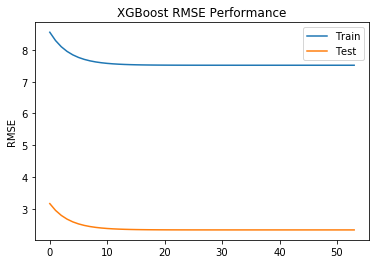


{'f0': 382, 'f1': 602}


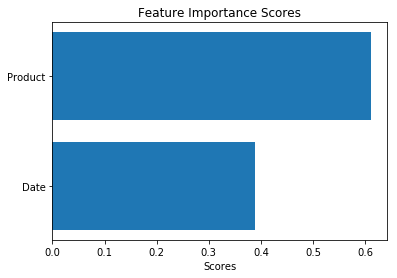

   Feature  Importance
0  Product    0.611789
1     Date    0.388211

Model building complete!
Time Elapsed: 0.6238248348236084 seconds
Complete!


In [31]:
print("4. Fitting data to model...")
model_xgb, cv_score, feature_importances, time_elapsed = fit_model_xgb(model_xgb, y_train, X_train, y_validation, X_validation, column_names)
print("Complete!")

### Generate predictions for test data

In [32]:
def generate_test_predictions(model, test):
    """ Takes fit XGBOOST model and test data as inputs. 
        Generates and returns model predictions on test data.
    """
    predictions = np.expm1(model.predict(test.values))
    return predictions  

In [34]:
print("5. Generating test set predictions...")
test_predictions = generate_test_predictions(model_xgb, test)  
print("Complete!")

5. Generating test set predictions...
Complete!


### Write predictions to CSV

In [69]:
def generate_submission_CSV_predictions(predictions, cv_score, model_name, cv_index): 
    """ Takes predictions, validation RMSLE score, string of model name, and index used for validation set as inputs. 
        Writes test predictions to CSV file.
    """             
    # Create dataframe with test predictions
    os.chdir('C:/Users/kpajm/tfdeeplearning') 
    df = pd.DataFrame(predictions, dtype = float, columns = ['Demand'])
    df_true = pd.read_csv('ceptes_data/data_test.csv')
    frames = [df_true, df]
    df = pd.concat(frames,axis=1)
    
    # Write to csv
    os.chdir('C:/Users/kpajm/tfdeeplearning/ceptes_data/submissions')  
    name = 'result_' + model_name + '.csv'
    df.to_csv(name, header = True,index = False)
    os.chdir('C:/Users/kpajm/tfdeeplearning/ceptes_data/data')
    return df

In [73]:
print("6. Writing predictions to CSV") 
df = generate_submission_CSV_predictions(test_predictions, cv_score, model_name = 'ceptes_project', cv_index = cv_index)

6. Writing predictions to CSV


In [75]:
df.head()

,Date,Product,Demand,Demand
0,1,100,1,1.000525
1,1,101,1,1.000525
2,1,102,1,1.000525
3,1,103,1,1.398309
4,1,104,1,1.678577
